# Команда TEAM DREAM
**Состав комады:**
- Рыжков Максим (TM, PM, DA)
- Ли Сюань Линь
- Халиков Рифат Шавкатович (DA)
- Карманов Максим
- Буржимский Сергей Александрович (ML)
- Перминов Артем Александрович (ML, PM)

# КЕЙС №8 "Прогнозирование стоимости компании"
**Краткое описание кейса:**

Требуется определить стоимость кампании на основе косвенных признаков, таких как финансовые показатели, количество сотрудников, рыночная доля и другие факторы.

**Ожидаемый результат:**

Обученная модель регрессии, предсказывающая стоимость кампании по данным.

**Основной функционал:**
  - Сбор и подготовка данных (финансовые отчёты, рыночные данные)
  - Применение корреляционного анализа для выявления взаимосвязей между признаками и стоимостью
  - Построение регрессионных моделей (линейная регрессия, градиентный бустинг)
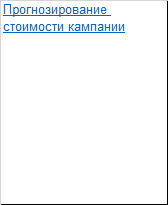

# Импорт библиотек

In [79]:
import pandas as pd                                     # для работы с таблицами (как Excel в коде)
import numpy as np                                      # для математических операций
import matplotlib.pyplot as plt                         # для графиков
import seaborn as sns                                   # для красивых графиков
from sklearn.model_selection import train_test_split    # для разделения данных
from sklearn.preprocessing import StandardScaler        # для нормализации данных
from sklearn.linear_model import LinearRegression       # простая модель
from sklearn.ensemble import GradientBoostingRegressor  # сложная модель
from sklearn.metrics import mean_squared_error, mean_absolute_error  # для оценки качества

# Загрузка данных

In [80]:
train_csv = pd.read_csv('../data/train.csv', usecols=lambda column: column != "id") # выгружаем данные и удаляем id (это просто идентификатор, не признак!)
test_csv = pd.read_csv('../data/test.csv', usecols=lambda column: column != "id") # выгружаем данные и удаляем id (это просто идентификатор, не признак!)

# Первичный анализ данных

In [81]:
print("\nИнформация о данных:")
print(train_csv.info())

print("\nОсновные статистики:")
print(train_csv.describe())


Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360336 entries, 0 to 360335
Data columns (total 16 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   store_sales(in millions)    360336 non-null  float64
 1   unit_sales(in millions)     360336 non-null  float64
 2   total_children              360336 non-null  float64
 3   num_children_at_home        360336 non-null  float64
 4   avg_cars_at home(approx).1  360336 non-null  float64
 5   gross_weight                360336 non-null  float64
 6   recyclable_package          360336 non-null  float64
 7   low_fat                     360336 non-null  float64
 8   units_per_case              360336 non-null  float64
 9   store_sqft                  360336 non-null  float64
 10  coffee_bar                  360336 non-null  float64
 11  video_store                 360336 non-null  float64
 12  salad_bar                   360336 non-null  float

## Анализ предоставленных данных:

Признаки (feature):

   Шкала отношений (Ratio scale):

    - store_sales (в миллионах) — продажи магазина
    - unit_sales (в миллионах) — объем продаж единиц товара
    - total_children — общее количество детей
    - num_children_at_home — количество детей дома
    - avg_cars_at_home — среднее количество автомобилей
    - gross_weight — вес товара
    - units_per_case — количество единиц в упаковке
    - store_sqft — площадь магазина

   Номинальная шкала (Nominal scale):

    - recyclable_package — возможность переработки упаковки
    - low_fat — содержание жира
    - coffee_bar
    - video_store
    - salad_bar
    - prepared_food
    - florist

## Разделение на признаки и целевую переменную

In [82]:
# Разделяем на признаки (X) и целевую переменную (y)
# Признаки - это то, на основе чего мы предсказываем
# Целевая переменная - то, что мы предсказываем (стоимость)

x = train_csv.drop("cost", axis=1)          # все колонки КРОМЕ cost
y = train_csv["cost"]                       # только колонка cost

## Проверка пропущенных значений

In [83]:
print("\nПропущенные значения")
print(x.isnull().sum())                           # посчитает пропуски в каждой колонке


Пропущенные значения
store_sales(in millions)      0
unit_sales(in millions)       0
total_children                0
num_children_at_home          0
avg_cars_at home(approx).1    0
gross_weight                  0
recyclable_package            0
low_fat                       0
units_per_case                0
store_sqft                    0
coffee_bar                    0
video_store                   0
salad_bar                     0
prepared_food                 0
florist                       0
dtype: int64


## Визуализация распределения целевой переменной

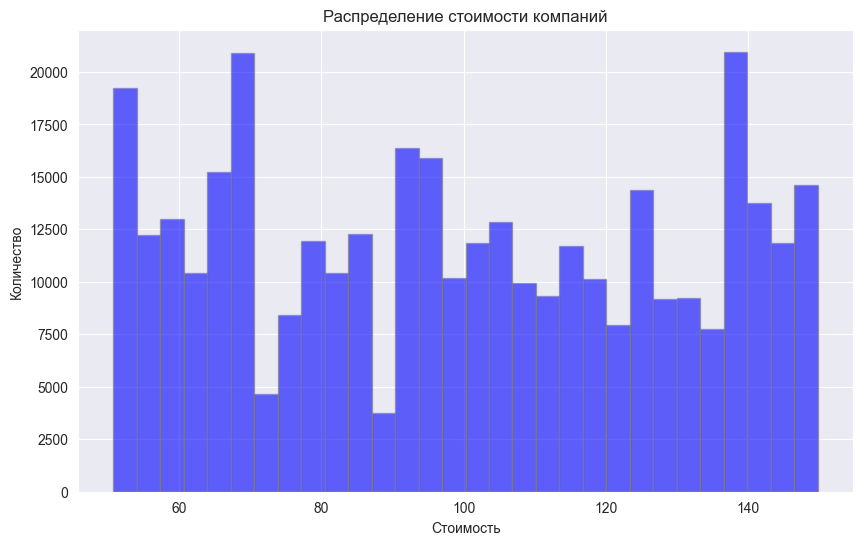

In [84]:
# 1. Смотрим на распределение стоимости
plt.figure(figsize=(10, 6))
plt.hist(y, bins=30, alpha=0.6, color="blue", edgecolor="gray", linewidth=1)
plt.title("Распределение стоимости компаний")
plt.xlabel("Стоимость")
plt.ylabel("Количество")
plt.show()

## Анализ корреляций

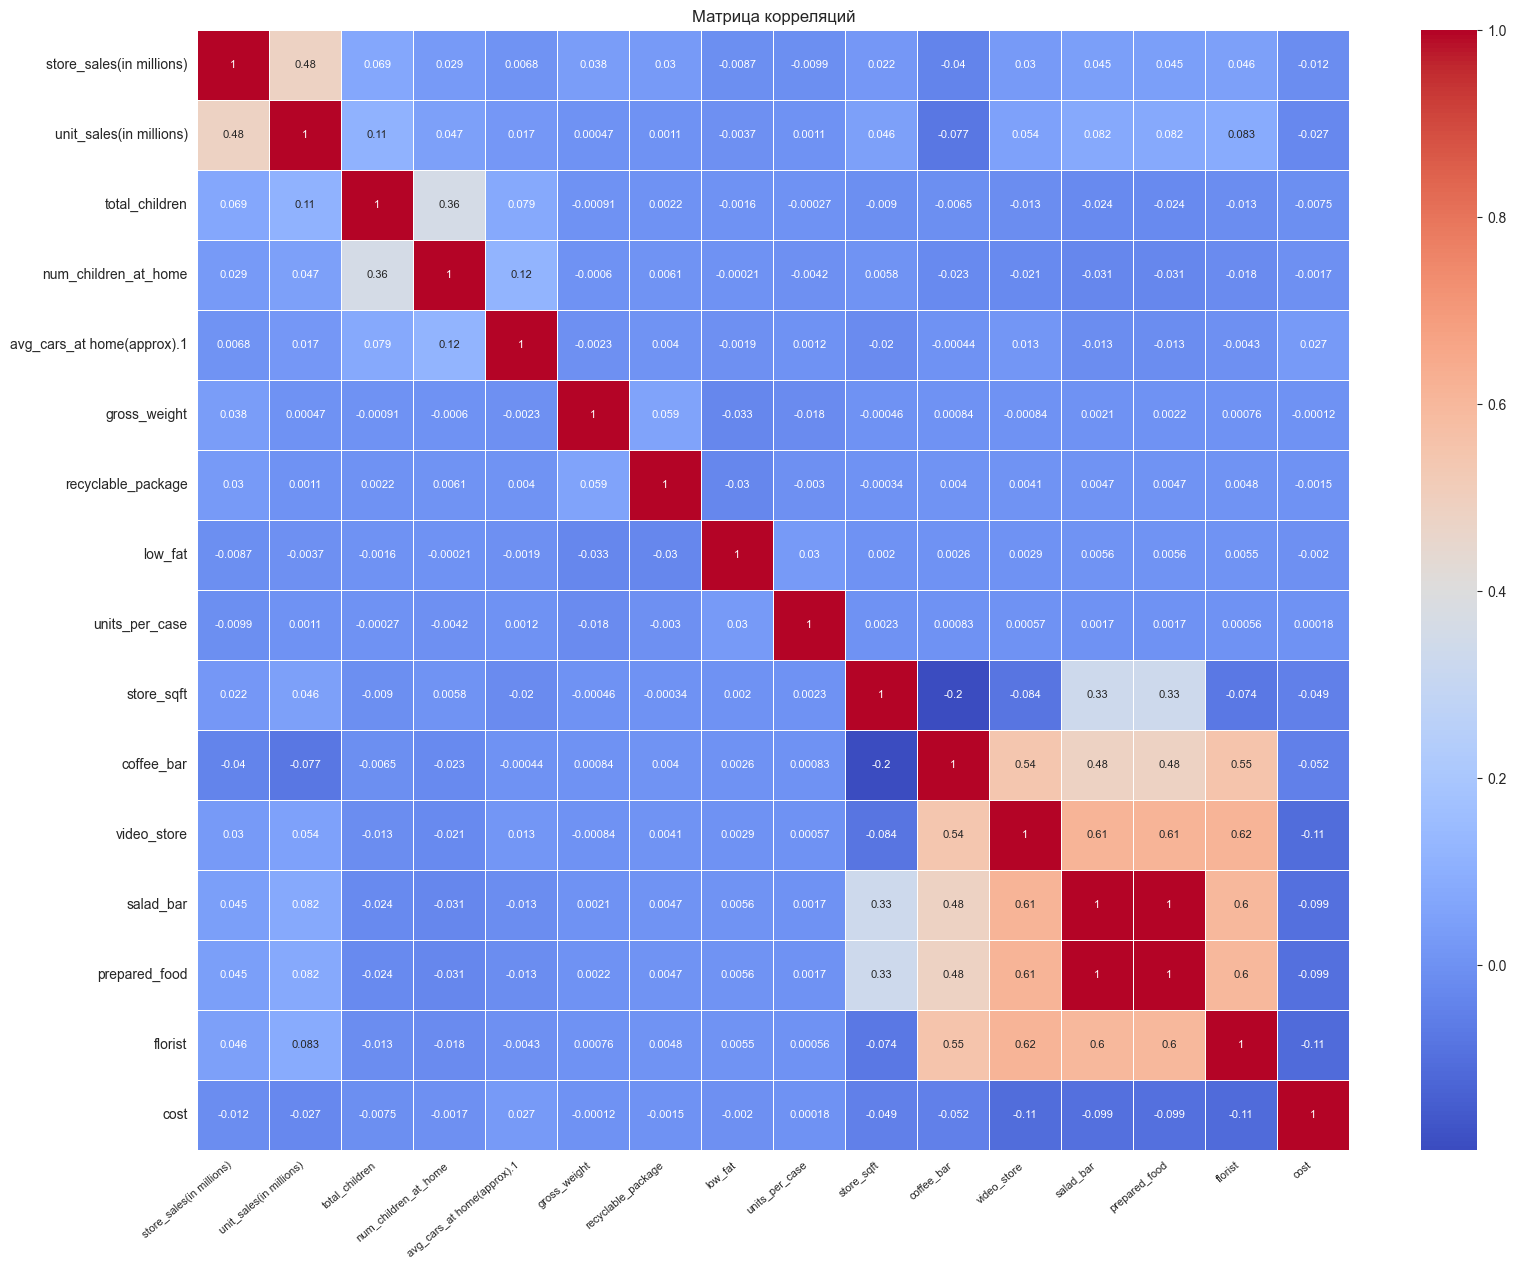

In [85]:
# 2. Смотрим корреляции (взаимосвязи между переменными)
plt.figure(figsize=(18, 14))
correlation_matrix = train_csv.corr()        # считаем корреляции
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, linecolor="white", annot_kws={"size": 8})
plt.title("Матрица корреляций")
plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)
plt.xticks(rotation=40, ha='right', fontsize=8)
plt.show()

## Отбор значимых признаков

In [86]:
# 3. Смотрим на самые важные признаки для стоимости
correlation_with_cost = correlation_matrix["cost"].sort_values(ascending=False)
print("\nКорреляция признаков со стоимостью:")
print(correlation_with_cost)


Корреляция признаков со стоимостью:
cost                          1.000000
avg_cars_at home(approx).1    0.027098
units_per_case                0.000180
gross_weight                 -0.000116
recyclable_package           -0.001455
num_children_at_home         -0.001727
low_fat                      -0.001975
total_children               -0.007482
store_sales(in millions)     -0.012387
unit_sales(in millions)      -0.026509
store_sqft                   -0.049201
coffee_bar                   -0.052086
salad_bar                    -0.098810
prepared_food                -0.098843
video_store                  -0.106786
florist                      -0.110414
Name: cost, dtype: float64


# Базовая модель

## Визуализируем топ-10 признаков по корреляции со стоимостью

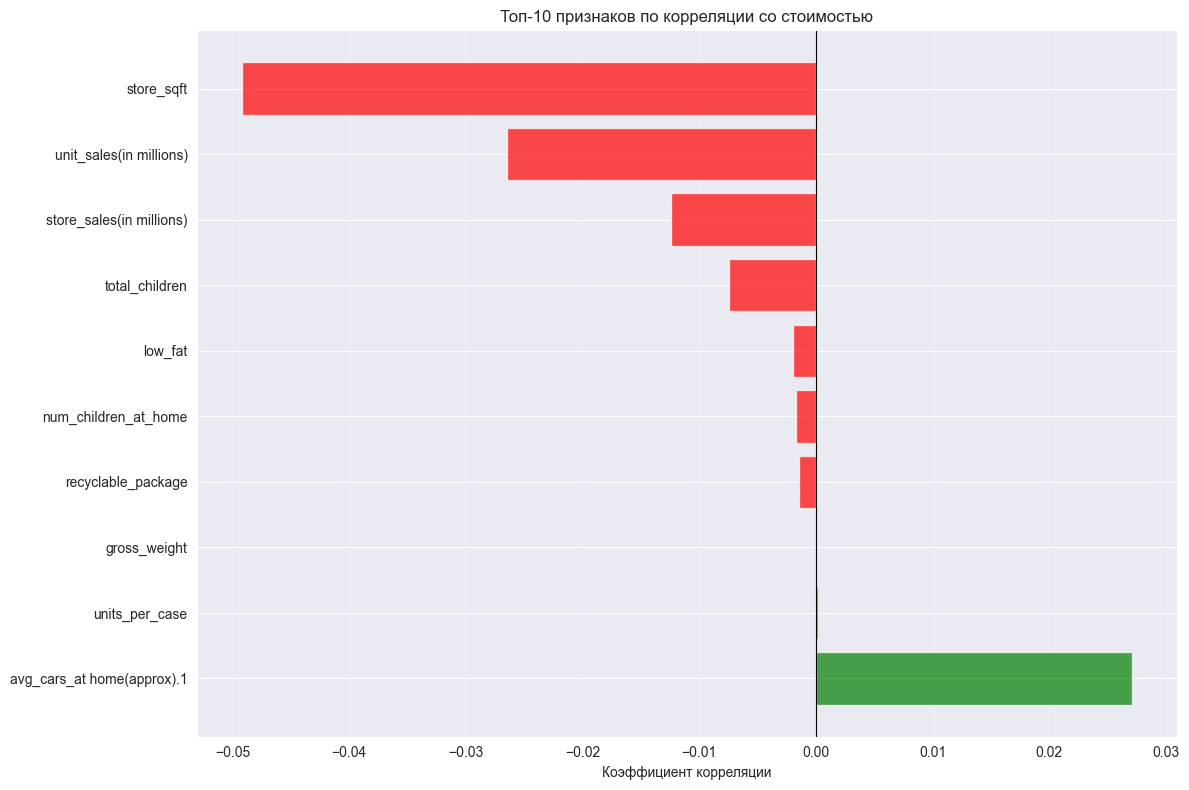

In [87]:
plt.figure(figsize=(12, 8))
top_correlations = correlation_with_cost.drop("cost").head(10)
colors = ['green' if x > 0 else 'red' for x in top_correlations.values]
plt.barh(range(len(top_correlations)), top_correlations.values, color=colors, alpha=0.7)
plt.yticks(range(len(top_correlations)), top_correlations.index)
plt.xlabel("Коэффициент корреляции")
plt.title("Топ-10 признаков по корреляции со стоимостью")
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Делим данные для обучения и теста

In [88]:

# Возьмем 80% для обучения, 20% для тестирования
# random_state=42 для того чтобы результат можно было повторить
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

print(f"Размер тренировочного набора: {X_train.shape[0]} примеров")
print(f"Размер тестового набора: {X_test.shape[0]} примеров")
print(f"Количество признаков: {X_train.shape[1]}")

Размер тренировочного набора: 288268 примеров
Размер тестового набора: 72068 примеров
Количество признаков: 15


## Нормализуем данные

In [89]:
# Нормализуем данные: приводим все признаки к одной шкале (среднее=0, стандартное отклонение=1)
scaler = StandardScaler()

# Обучаем нормализатор на тренировочных данных
X_train_scaled = scaler.fit_transform(X_train)

# Применяем ту же нормализацию к тестовым данным
X_test_scaled = scaler.transform(X_test)

print("Тренировочные данные после нормализации:")
print(f"Среднее значение: {X_train_scaled.mean(axis=0)[:5].round(4)}")  # показываем первые 5 признаков
print(f"Стандартное отклонение: {X_train_scaled.std(axis=0)[:5].round(4)}")

Тренировочные данные после нормализации:
Среднее значение: [ 0. -0. -0. -0. -0.]
Стандартное отклонение: [1. 1. 1. 1. 1.]


# Baseline модели

In [90]:
# Создаем и обучаем модель линейной регрессии
baseline_model = LinearRegression()

# Обучаем на нормализованных тренировочных данных
baseline_model.fit(X_train_scaled, y_train)

# Проверяем на тренировочном и тестовом наборах
y_train_pred = baseline_model.predict(X_train_scaled)
y_test_pred = baseline_model.predict(X_test_scaled)

print(f"\nКоэффициенты модели (первые 5):")
for i in range(min(5, len(baseline_model.coef_))):
    print(f"  {X_train.columns[i]}: {baseline_model.coef_[i]:.4f}")
print(f"\nКонстанта модели: {baseline_model.intercept_:.4f}")


Коэффициенты модели (первые 5):
  store_sales(in millions): 0.0873
  unit_sales(in millions): -0.3213
  total_children: -0.3110
  num_children_at_home: -0.0899
  avg_cars_at home(approx).1: 0.8213

Константа модели: 99.6413


In [91]:
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"\nМетрики на тренировочном наборе:")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  MAE: {train_mae:.4f}")

print(f"\nМетрики на тестовом наборе:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE: {test_mae:.4f}")


Метрики на тренировочном наборе:
  RMSE: 29.6431
  MAE: 25.5734

Метрики на тестовом наборе:
  RMSE: 29.6570
  MAE: 25.6016


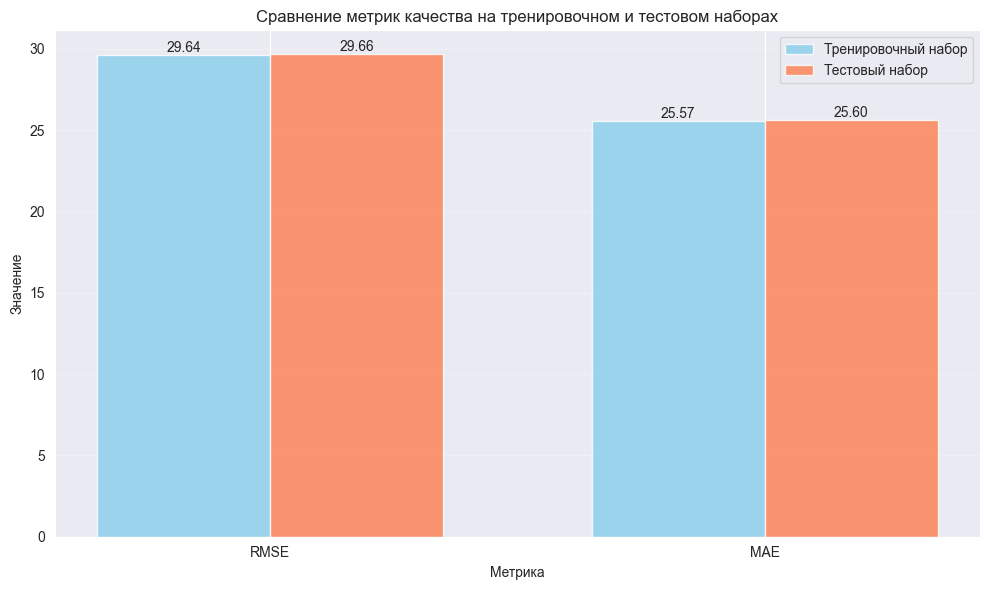

In [92]:
# Сравнение метрик на тренировочном и тестовом наборах
metrics_data = {
    'RMSE': [train_rmse, test_rmse],
    'MAE': [train_mae, test_mae]
}

fig, ax = plt.subplots(figsize=(10, 6))
x_pos = np.arange(len(metrics_data))
width = 0.35

bars1 = ax.bar(x_pos - width/2, [metrics_data[m][0] for m in metrics_data], width, 
               label='Тренировочный набор', alpha=0.8, color='skyblue')
bars2 = ax.bar(x_pos + width/2, [metrics_data[m][1] for m in metrics_data], width,
               label='Тестовый набор', alpha=0.8, color='coral')

ax.set_xlabel('Метрика')
ax.set_ylabel('Значение')
ax.set_title('Сравнение метрик качества на тренировочном и тестовом наборах')
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics_data.keys())
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Значения над столбками
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()